# Plot locations of shelf exit around the continental margin

Import Libraries.

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from glob import glob
import gsw
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors

import cartopy.crs as ccrs
import cartopy.feature as cft
import cartopy.mpl.ticker as cticker
import cmocean as cm # beautiful colour maps
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
from pathlib import Path
# in jupyter (lab / notebook), based on notebook path
module_path = str(Path.cwd().parents[0] )
if module_path not in sys.path:
    sys.path.append(module_path)
import custom_functions as cf

Read in datasets.

In [3]:
startfile = '/g/data/e14/hd4873/runs/parcels/output/AntConn/data/CircumAntarcticParticles_initial_values.nc'
ref = xr.open_dataset(startfile).load()
p_exit = gsw.p_from_z(-ref.shelf_exit_z, ref.shelf_exit_lat)
sa_exit = gsw.SA_from_SP(ref.shelf_exit_S, p_exit, ref.shelf_exit_lon, ref.shelf_exit_lat)
ref['sigma0_exit'] = gsw.density.sigma0(sa_exit, ref.shelf_exit_T)
ref['sigma1_exit'] = gsw.density.sigma1(sa_exit, ref.shelf_exit_T)

# Find particles that exit shelf** (some stay on the shelf their entire 'lifetime' - we don't want to include these.)
exitparts = np.where(ref.shelf_exit_indx < 1512)[0] #1512 is last time index of simulation
print(len(exitparts))

9259897


In [4]:
pxy_dense_02 = xr.open_dataset('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/2Dpxy/2Dpxy_dense_waters_after_exit_sigma0_27.8.nc')
pxy_dense_02['pxy_trans_pct'] = pxy_dense_02.pxy_trans_pct/100.
# coarser res offshore locations:
#sig0_20_2775 = xr.open_dataset('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/offshore/OffshoreParticles_2x1degree_20-27.75sigma0.nc')
#sig0_2775_278 = xr.open_dataset('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/offshore/OffshoreParticles_2x1degree_27.75-27.8sigma0.nc')
#sig0_278_30 = xr.open_dataset('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/offshore/OffshoreParticles_2x1degree_27.8-30sigma0.nc')
# finer res offshore locations:
sig0_20_2775 = xr.open_dataset('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/offshore/OffshoreParticles_1x0.5degree_20-27.75sigma0.nc')
sig0_2775_278 = xr.open_dataset('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/offshore/OffshoreParticles_1x0.5degree_27.75-27.8sigma0.nc')
sig0_278_30 = xr.open_dataset('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/offshore/OffshoreParticles_1x0.5degree_27.8-30sigma0.nc')

# dataset with exit locations of all particles (not split by density)
#file = '/g/data/e14/hd4873/runs/parcels/output/AntConn/data/offshore/OffshoreParticles_2x1degree_20-30sigma0.nc' # coarser res
file = '/g/data/e14/hd4873/runs/parcels/output/AntConn/data/offshore/OffshoreParticles_1x0.5degree_20-30sigma0.nc' # finer res
ds = xr.open_dataset(file)

# create a dataset with the summed values of (transport weighting * shelf weighting)
# for all particles that are released along the shelf in each 1 deg longitude bin
normtransarr = np.full(len(ds.lon), 0)
for i in range(len(normtransarr)):
    ids = np.where((ref.lon >= ds.lon[i]- 1) & (ref.lon < ds.lon[i]))[0]
    if len(ids) > 0:
        normtransarr[i] = (np.abs(ref.trans[ids])*ref.shelf_weighted_val[ids]).sum()

# as above but just for shelf weighting (no particle transport weighting)
normarr = np.full(len(ds.lon), 0)
for i in range(len(normtransarr)):
    ids = np.where((ref.lon >= ds.lon[i]- 1) & (ref.lon < ds.lon[i]))[0]
    if len(ids) > 0:
        normarr[i] = ref.shelf_weighted_val[ids].sum()

Define figure function and some other data for plotting.

In [5]:
ht = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/ocean_grid.nc').ht[:1000,:] 
hu = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/ocean_grid.nc').hu[:509,:] 
land_mask = (hu*0).fillna(1)
#land_mask_masked = land_mask.where(land_mask == 1)
land_mask_masked = land_mask.where(land_mask == 1)
yu_ocean = hu.yu_ocean.values
xu_ocean = hu.xu_ocean.values
hu_shelf, shelf_mask = cf.shelf_mask_isobath(hu)

# define land mask
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='gray',
                                        linewidth=0.2)

def figure05(color1):
    
    fig = plt.figure(constrained_layout=True, figsize=(16,10)) #12, 8
    spec = gridspec.GridSpec(ncols=1, nrows=3, figure=fig)
    ax1 = fig.add_subplot(spec[0, :])
    ax1a = fig.add_subplot(spec[1, :])
    ax2 = fig.add_subplot(spec[2, :], projection=ccrs.Mercator(central_longitude=260)) #260
    
    # subplot 1
    ax1.set_xlim([-280, 80])
    ax1.tick_params(axis='x', labelsize= 13)
    ax1.tick_params(axis='y', labelsize= 13, colors=color1)
    ax1.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter(useMathText=True, useOffset=False))
    ax1.yaxis.label.set_color(color1)
    labels = ["80", "110\u00B0E", "160\u00B0E", "150\u00B0W", "100\u00B0W", "50\u00B0W", "0\u00B0E", "50\u00B0E"]
    ax1.set_xticklabels([labels])
    
    # subplot 2
    ax1a.set_xlim([-280, 80])
    ax1a.tick_params(axis='x', labelsize= 13)
    ax1a.tick_params(axis='y', labelsize= 13, colors=color1)
    ax1a.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter(useMathText=True, useOffset=False))
    ax1a.yaxis.label.set_color(color1)
    ax1a.set_xticklabels(labels)
    
    # subplot 3
    ax2.contour(xu_ocean, yu_ocean, shelf_mask.values, [0,1], colors='k', alpha=1, 
                linewidths=1.5, zorder=2, transform = ccrs.PlateCarree())
    ax2.pcolormesh(xu_ocean, yu_ocean, land_mask_masked.values, zorder=1,
               cmap = 'tab20c_r', alpha=1, linewidths=1.2,transform = ccrs.PlateCarree(),)
    ax2.contour(xu_ocean, yu_ocean, land_mask.values, [0,1], zorder=1,
             colors='dimgrey', alpha=1, linewidths=0.6, transform = ccrs.PlateCarree())
    #masktmp = mask.basins.where(mask.basins==1)
    #ax2.pcolormesh(mask.xu_ocean, mask.yu_ocean, masktmp.where(land_mask == 0),
    #              cmap=cm.cm.dense, vmin=0, vmax=3.5, alpha=0.8, #'tab20c_r'
    #              transform = ccrs.PlateCarree())
    xticks = [-200, -150, -100, -50, 0, 50, 110,]
    ax2.set_xticks(xticks, crs=ccrs.PlateCarree())
    yticks = [-78, -75, -70, -65, -60]
    ax2.set_yticks(yticks, crs=ccrs.PlateCarree())
    ax2.xaxis.set_major_formatter(LongitudeFormatter())
    ax2.yaxis.set_major_formatter(LatitudeFormatter()) 
    ax2.tick_params(axis='x', labelsize= 13)
    ax2.tick_params(axis='y', labelsize= 13)
    
    fig.subplots_adjust(hspace=0.15)#, wspace=0.015, )
    
    return fig, ax1, ax1a, ax2

Plot figure. 

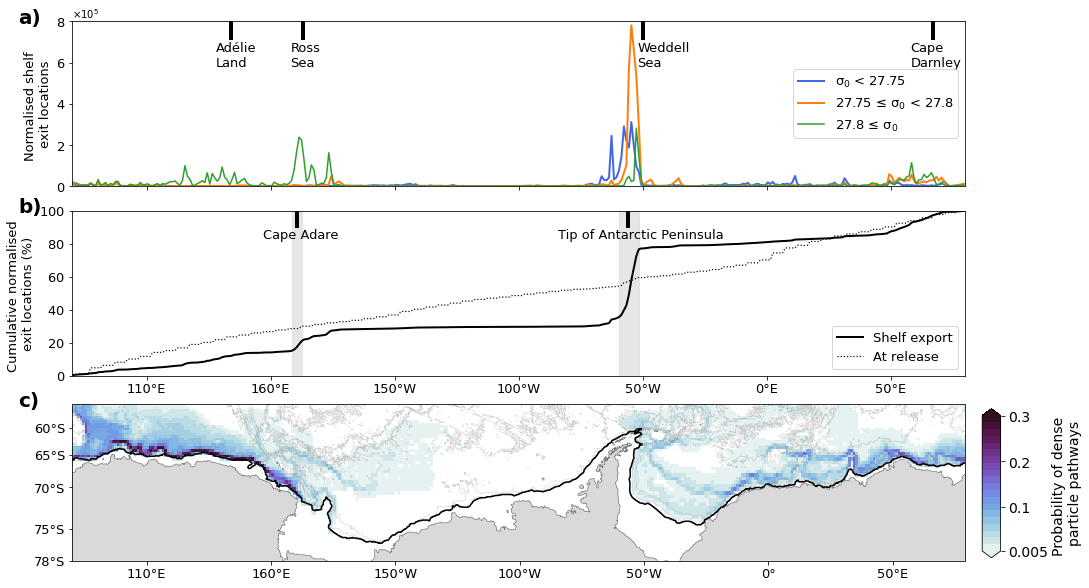

In [7]:
weight = 1  # weighting boolean to indicate transport weighting (or not)
            # 1 = particle count weighted by transport value and normalised shelf value
            # 0 = particle count weighted by normalised shelf value only

fig5, ax1, ax2, ax3 = figure05('k')
subplot_labels =['a)', 'b)', 'c)']
minpct = 0.005

# subplot 1
if weight == 1:
    ax1.plot(sig0_20_2775.lon, sig0_20_2775.count_transnorm.sum(dim='lat'), 
             linewidth = 2, c = 'royalblue', linestyle = '-',
             label=u'\u03C3$_0$ < 27.75') 
    ax1.plot(sig0_2775_278.lon, sig0_2775_278.count_transnorm.sum(dim='lat'), 
             linewidth = 2, c = 'tab:orange', linestyle = '-',
             label=u'27.75 ≤ \u03C3$_0$ < 27.8')
    ax1.plot(sig0_278_30.lon, sig0_278_30.count_transnorm.sum(dim='lat'), 
             linewidth = 1.5, c = 'tab:green', linestyle = '-',
             label=u'27.8 ≤ \u03C3$_0$ ')
    ax1.set_ylabel('Normalised shelf \nexit locations', fontsize=13)
    ax1.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter(useMathText=True, useOffset=False))
    ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useOffset=None, useLocale=None, useMathText=None)
    marker_bottom, marker_top =  720000, 800000
    label_pos = 580000
    ax1.set_ylim([0, 800000])
else:
    ax1.plot(sig0_20_2775.lon, sig0_20_2775.count_norm.sum(dim='lat'), 
             linewidth = 2, c = 'royalblue', linestyle = '-',
             label=u'\u03C3$_0$ < 27.75') 
    ax1.plot(sig0_2775_278.lon, sig0_2775_278.count_norm.sum(dim='lat'), 
             linewidth = 2, c = 'tab:orange', linestyle = '-',
             label=u'27.75 ≤ \u03C3$_0$ < 27.8')
    ax1.plot(sig0_278_30.lon, sig0_278_30.count_norm.sum(dim='lat'), 
             linewidth = 1.5, c = 'tab:green', linestyle = '-',
             label=u'27.8 ≤ \u03C3$_0$ ')
    marker_bottom, marker_top =  285, 310
    label_pos = 225
    ax1.set_ylim([0, 310])
ax1.legend(loc='center right', fontsize=13)
ax1.text(-0.06, 0.99, subplot_labels[0], fontweight='bold', fontsize=20, transform=ax1.transAxes)
# Plot bottom water formation sites
ax1.plot([144-360, 144-360], [marker_bottom, marker_top],linewidth = 4, c = 'k', linestyle = '-',)
ax1.plot([173-360, 173-360], [marker_bottom, marker_top],linewidth = 4, c = 'k', linestyle = '-',)
ax1.plot([67, 67], [marker_bottom, marker_top],linewidth = 4, c = 'k', linestyle = '-',)
ax1.plot([-50, -50], [marker_bottom, marker_top],linewidth = 4, c = 'k', linestyle = '-',)
ax1.text(138-360, label_pos,'Adélie\nLand',color = 'k', fontsize=13)
ax1.text(168-360, label_pos,'Ross\nSea',color = 'k', fontsize=13)
ax1.text(-52, label_pos,'Weddell\nSea',color = 'k', fontsize=13)
ax1.text(58, label_pos,'Cape\nDarnley',color = 'k', fontsize=13)

# subplot 2
# plot cumulative sum of particle exit locations
if weight == 1:
    arr = ds.count_transnorm.sum(dim='lat')
    transnorm_tot = (np.abs(ref.trans[exitparts])*ref.shelf_weighted_val[exitparts]).sum()
    ln1 = ax2.plot(ds.lon, arr.cumsum()/transnorm_tot*100, 
                    linewidth = 2, c = 'k', linestyle = '-',
                    label='Shelf export') 
    # plot cumulative sum of particle release locations (dotted line)
    transnorm_tot = (np.abs(ref.trans)*ref.shelf_weighted_val).sum()
    ln2 = ax2.plot(ds.lon, normtransarr.cumsum()/transnorm_tot.values*100, 
                    linewidth = 1.2, c = 'k', linestyle = ':',
                    label='At release') 
else:
    arr = ds.count_norm.sum(dim='lat')
    norm_tot = ref.shelf_weighted_val[exitparts].sum()
    ln1 = ax2.plot(ds.lon, arr.cumsum()/norm_tot*100, 
                    linewidth = 2, c = 'k', linestyle = '-',
                    label='Shelf export') 
    # plot cumulative sum of particle release locations (dotted line)
    norm_tot = ref.shelf_weighted_val.sum()
    ln2 = ax2.plot(ds.lon, normarr.cumsum()/norm_tot.values*100, 
                    linewidth = 1.2, c = 'k', linestyle = ':',
                    label='At release') 
ax2.set_ylim([0, 100])
ax2.set_ylabel('Cumulative normalised \nexit locations (%)', fontsize=13)
ax2.axvspan(ds.lon[88], ds.lon[92], alpha=0.7, color='gainsboro')
ax2.axvspan(ds.lon[220], ds.lon[228], alpha=0.7, color='gainsboro')
ax2.text(-0.06, 0.99, subplot_labels[1], fontweight='bold', fontsize=20, transform=ax2.transAxes)
labels = ["80", "110\u00B0E", "160\u00B0E", "150\u00B0W", "100\u00B0W", "50\u00B0W", "0\u00B0E", "50\u00B0E"]
ax2.set_xticklabels(labels,fontsize=13)
ax2.legend(loc='lower right', fontsize=13)
# plot export location labels
ax2.plot([170.7-360, 170.7-360], [91, 100],linewidth = 4, c = 'k', linestyle = '-',)
ax2.plot([-56, -56], [91, 100],linewidth = 4, c = 'k', linestyle = '-',)
ax2.text(157-360,83,'Cape Adare',color = 'k', fontsize=13)
ax2.text(-84, 83,'Tip of Antarctic Peninsula',color = 'k', fontsize=13)


# subplot 3
ax3.text(-0.06, 0.99, subplot_labels[2], fontweight='bold', fontsize=20, transform=ax3.transAxes)
cb = ax3.pcolormesh(pxy_dense_02.lon,pxy_dense_02.lat, pxy_dense_02.pxy_trans_pct.where(pxy_dense_02.pxy_trans_pct>minpct).T, 
                    cmap = cm.cm.dense._resample(20), vmin=minpct, vmax=0.30, zorder=1,transform = ccrs.PlateCarree())
ax3.contour(ht.xt_ocean, ht.yt_ocean, ht, [2000, 3000, 5000], colors='grey', linewidths=0.5, zorder=1, alpha = 0.4, transform = ccrs.PlateCarree())
ax3.set_extent([-280, 79, -78, -55], crs=ccrs.PlateCarree())

# Add a colorbar 
cbar_ax = fig5.add_axes([0.915, 0.135, 0.016, 0.207])#0.135
# Draw the colorbar
cbar=fig5.colorbar(cb, cax=cbar_ax,orientation='vertical', extend='both')
cbar.set_label('Probability of dense \nparticle pathways', fontsize=14)#, rotation=270)
cbar.set_ticks([minpct, 0.10, 0.20, 0.30])#, rotation=270)
cbar.set_ticklabels([minpct, 0.10, 0.20, 0.30])#, rotation=270)
cbar.ax.tick_params(labelsize=14)

# save to file
outdir = '/g/data/e14/hd4873/runs/parcels/output/AntConn/figures/for_publication/'
if weight == 1:
    outfile = outdir + 'Fig06_shelf_exit_locations_1x0.5deg_transweightednorm.jpg'
else:
    outfile = outdir + 'Fig06_shelf_exit_locations_1x0.5deg_norm.jpg'
fig5.savefig(outfile, dpi=300, bbox_inches='tight')

plt.show()